In [1]:
import scipy.ndimage
import psi4
import pdft
%matplotlib notebook
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import libcubeprop
import numpy as np

In [2]:
psi4.set_output_file("HeALL96")

In [8]:
def weight(D1, D2, Vpot, beta=6):
    C = 6 / 4 / (4 * np.pi) ** 1.5

    points_func = Vpot.properties()[0]
    superfunc = Vpot.functional()

    density1 = 0.0
    density2 = 0.0

    xc_e = 0.0
    vv10_e = 0.0
    w1 = []
    w2 = []
    w3 = []
    w4 = []
    g1 = []
    g2 = []
    wv1 = []
    wv2 = []
    # First loop over the outer set of blocks
    #     for l_block in range(Vpot.nblocks()):
    for l_block in range(Vpot.nblocks()):
        # Obtain general grid information
        l_grid = Vpot.get_block(l_block)
        l_w = np.array(l_grid.w())
        l_x = np.array(l_grid.x())
        l_y = np.array(l_grid.y())
        l_z = np.array(l_grid.z())
        l_npoints = l_w.shape[0]

        points_func.compute_points(l_grid)
        l_lpos = np.array(l_grid.functions_local_to_global())

        # Compute phi!
        l_phi = np.array(points_func.basis_values()["PHI"])[:l_npoints, :l_lpos.shape[0]]
        l_phi_x = np.array(points_func.basis_values()["PHI_X"])[:l_npoints, :l_lpos.shape[0]]
        l_phi_y = np.array(points_func.basis_values()["PHI_Y"])[:l_npoints, :l_lpos.shape[0]]
        l_phi_z = np.array(points_func.basis_values()["PHI_Z"])[:l_npoints, :l_lpos.shape[0]]
        # Build a local slice of D
        lD1 = D1[(l_lpos[:, None], l_lpos)]

        # Copmute block-rho and block-gamma
        rho1 = np.einsum('pm,mn,pn->p', l_phi, lD1, l_phi, optimize=True)
        # 2.0 for Px D P + P D Px, 2.0 for non-spin Density
        rho_x1 = 2.0 * np.einsum('pm,mn,pn->p', l_phi, lD1, l_phi_x, optimize=True)
        rho_y1 = 2.0 * np.einsum('pm,mn,pn->p', l_phi, lD1, l_phi_y, optimize=True)
        rho_z1 = 2.0 * np.einsum('pm,mn,pn->p', l_phi, lD1, l_phi_z, optimize=True)
        gamma1 = rho_x1 ** 2 + rho_y1 ** 2 + rho_z1 ** 2

        # The integral cutoff.
        l_local_w_homo = gamma1 ** 0.5 < 2 * beta / (9 * np.pi) ** (1.0 / 6.0) * (rho1 ** (7.0 / 6.0))
        #         l_local_w_gamma = gamma1 > threshold_gamma
        l_local_w_rho = rho1 > 1e-9
        l_local_w_ls =  2 * beta / (9 * np.pi) ** (1.0 / 6.0) * (rho1 ** (7.0 / 6.0)) > 1e-5
        l_local_w = l_local_w_homo * l_local_w_rho * l_local_w_ls
        #         l_local_w = l_local_w_homo

        # Build a local slice of D
        lD2 = D2[(l_lpos[:, None], l_lpos)]

        # Copmute block-rho and block-gamma
        rho2 = 1.0 * np.einsum('pm,mn,pn->p', l_phi, lD2, l_phi, optimize=True)
        # 2.0 for Px D P + P D Px, 2.0 for non-spin Density
        rho_x2 = 2.0 * np.einsum('pm,mn,pn->p', l_phi, lD2, l_phi_x, optimize=True)
        rho_y2 = 2.0 * np.einsum('pm,mn,pn->p', l_phi, lD2, l_phi_y, optimize=True)
        rho_z2 = 2.0 * np.einsum('pm,mn,pn->p', l_phi, lD2, l_phi_z, optimize=True)
        gamma2 = rho_x2 ** 2 + rho_y2 ** 2 + rho_z2 ** 2

        # The integrate cutoff.
        r_local_w_homo = gamma2 ** 0.5 <= 2 * beta / (9 * np.pi) ** (1.0 / 6.0) * (rho2 ** (7.0 / 6.0))
        r_local_w_rho = rho2 > 1e-9
        r_local_w_ls =  2 * beta / (9 * np.pi) ** (1.0 / 6.0) * (rho2 ** (7.0 / 6.0)) > 1e-5
        r_local_w = r_local_w_homo * r_local_w_rho * r_local_w_ls
        #         r_local_w = r_local_w_homo

        density1 += np.sum(rho1 * l_w)
        density2 += np.sum(rho2 * l_w)

        w1.extend(r_local_w_rho + l_local_w_rho * 2)
        w2.extend(r_local_w_homo + l_local_w_homo * 2)
        w3.extend(r_local_w_ls + l_local_w_ls* 2)
        w4.extend(r_local_w + l_local_w * 2)
        g1.extend(gamma1**0.5)
        g2.extend(gamma2**0.5)
        wv1.extend(2 * beta / (9 * np.pi) ** (1.0 / 6.0) * (rho1 ** (7.0 / 6.0)))
        wv2.extend(2 * beta / (9 * np.pi) ** (1.0 / 6.0) * (rho2 ** (7.0 / 6.0)))
    x, y, z, _ = Vpot.get_np_xyzw()
    w1 = np.array(w1).astype('int')
    w2 = np.array(w2).astype('int')
    w3 = np.array(w3).astype('int')
    w4 = np.array(w4).astype('int')
    g1 = np.array(g1)
    g2 = np.array(g2)
    wv1 = np.array(wv1)
    wv2 = np.array(wv2)
    print(density1, density2)
    return (x,y,z),(w1, w2, w3, w4),(g1,g2),(wv1,wv2)

In [4]:
def find_vp_all96(self, vp_maxiter, scf_maxiter, guess=None, rtol=1e-3, seperation_cutoff=None):
    """
    vp = vp_non-local = vp_all96. Total scf iteration max = vp_maxiter*scf_maxiter*num_fragments + entire system scf

    :param vp_maxiter: maximum num of vp update iteration needed.
    :param vp_maxiter: maximum num of scf update iteration needed.
    :param guess: Initial guess of vp.
    :param rtol: Relative ALL96 energy difference as the convergence criteria.
    :para seperation_cutoff: a very crude cutoff to avoid singularity: if a piece |r1-r2| is smaller than this value, 
          it will be neglected in the integral. The reason is that Gaussian basis sets are bad around the nucleus. 
          Thus the cutoff of one fragment will not kill the density around the other fragments' nucleus. 
          I designed this hard cutoff to overcome this. A loose upper-bound for seperation_cutoff is the seperation between
          the two nucleus.
    :return:
    """
    # Run the initial
    self.fragments_scf(scf_maxiter)

    all96_e_old = 0.0
    vp_fock_all96_old = 0.0
    for vp_step in range(1, vp_maxiter+1):
        self.get_density_sum()
        # Initial vp_all96
        all96_e, vp_all96, vp_fock_all96 = self.vp_all96(seperation_cutoff=seperation_cutoff)
        print("Iteration % i, ALL96 E %.14f, ALL96 E difference %.14f" % (vp_step, all96_e, abs((all96_e_old - all96_e) / all96_e)))
        if abs((all96_e_old - all96_e) / all96_e) < rtol and np.linalg.norm(vp_fock_all96_old - vp_fock_all96) < rtol:
            print("ALL96 Energy Converged:", all96_e)
            break
        all96_e_old = all96_e
        vp_fock_all96_old = vp_fock_all96
        vp_fock_psi4 = psi4.core.Matrix.from_array(vp_fock_all96)
        self.fragments_scf(scf_maxiter, vp_fock=[vp_fock_psi4, vp_fock_psi4])

    return all96_e, vp_all96, vp_fock_all96

def vp_all96(self, beta=6, seperation_cutoff=None):
    """
    Return vp on grid and vp_fock on the basis.
    :para seperation_cutoff: a very crude cutoff to avoid singularity: if a piece |r1-r2| is smaller than this value, 
    it will be neglected in the integral. The reason is that Gaussian basis sets are bad around the nucleus. 
    Thus the cutoff of one fragment will not kill the density around the other fragments' nucleus. 
    I designed this hard cutoff to overcome this. A loose upper-bound for seperation_cutoff is the seperation between
    the two nucleus.
    """

    C = -6.0 / 4.0 / (4 * np.pi) ** 1.5

    vp = np.zeros_like(self.molecule.Vpot.get_np_xyzw()[-1])
    vp_fock = np.zeros_like(self.fragments[0].Da.np)

    points_func = self.molecule.Vpot.properties()[0]

    w1_old = 0

    all96_e = 0.0

    # First loop over the outer set of blocks
    for l_block in range(self.molecule.Vpot.nblocks()):
        #     for l_block in range(70, Vpot.nblocks()):
        # Obtain general grid information
        l_grid = self.molecule.Vpot.get_block(l_block)
        l_w = np.array(l_grid.w())
        l_x = np.array(l_grid.x())
        l_y = np.array(l_grid.y())
        l_z = np.array(l_grid.z())
        l_npoints = l_w.shape[0]

        points_func.compute_points(l_grid)
        l_lpos = np.array(l_grid.functions_local_to_global())

        # Compute phi!
        l_phi = np.array(points_func.basis_values()["PHI"])[:l_npoints, :l_lpos.shape[0]]
        l_phi_x = np.array(points_func.basis_values()["PHI_X"])[:l_npoints, :l_lpos.shape[0]]
        l_phi_y = np.array(points_func.basis_values()["PHI_Y"])[:l_npoints, :l_lpos.shape[0]]
        l_phi_z = np.array(points_func.basis_values()["PHI_Z"])[:l_npoints, :l_lpos.shape[0]]
        # Build a local slice of D
        lD1 = self.fragments[0].Da.np[(l_lpos[:, None], l_lpos)]

        # Copmute block-rho and block-gamma
        rho1 = 2.0 * np.einsum('pm,mn,pn->p', l_phi, lD1, l_phi, optimize=True)

        total_rho1 = 2.0 * np.einsum('pm,mn,pn->p', l_phi, lD1 + self.fragments[1].Da.np[(l_lpos[:, None], l_lpos)], l_phi,
                                     optimize=True)

        # 2.0 for Px D P + P D Px, 2.0 for non-spin Density
        rho_x1 = 4.0 * np.einsum('pm,mn,pn->p', l_phi, lD1, l_phi_x, optimize=True)
        rho_y1 = 4.0 * np.einsum('pm,mn,pn->p', l_phi, lD1, l_phi_y, optimize=True)
        rho_z1 = 4.0 * np.einsum('pm,mn,pn->p', l_phi, lD1, l_phi_z, optimize=True)
        gamma1 = rho_x1 ** 2 + rho_y1 ** 2 + rho_z1 ** 2

        # The integral cutoff.
        l_local_w_homo = gamma1 ** 0.5 <= 2 * beta * ((9 * np.pi) ** (-1.0 / 6.0)) * (rho1 ** (7.0 / 6.0))
        l_local_w_rho = rho1 > 1e-17
        l_local_w = l_local_w_homo * l_local_w_rho

        if not np.any(l_local_w):
            w1_old += l_npoints
            continue

        w2_old = 0
        l_integrant = np.zeros_like(rho1)
        dvp_l = np.zeros(l_npoints)
        # Loop over the inner set of blocks
        for r_block in range(self.molecule.Vpot.nblocks()):

            r_grid = self.molecule.Vpot.get_block(r_block)
            r_w = np.array(r_grid.w())
            r_x = np.array(r_grid.x())
            r_y = np.array(r_grid.y())
            r_z = np.array(r_grid.z())
            r_npoints = r_w.shape[0]

            points_func.compute_points(r_grid)
            r_lpos = np.array(r_grid.functions_local_to_global())

            # Compute phi!
            r_phi = np.array(points_func.basis_values()["PHI"])[:r_npoints, :r_lpos.shape[0]]
            r_phi_x = np.array(points_func.basis_values()["PHI_X"])[:r_npoints, :r_lpos.shape[0]]
            r_phi_y = np.array(points_func.basis_values()["PHI_Y"])[:r_npoints, :r_lpos.shape[0]]
            r_phi_z = np.array(points_func.basis_values()["PHI_Z"])[:r_npoints, :r_lpos.shape[0]]

            # Build a local slice of D
            lD2 = self.fragments[1].Da.np[(r_lpos[:, None], r_lpos)]

            total_rho2 = 2.0 * np.einsum('pm,mn,pn->p', r_phi, self.fragments[0].Da.np[(r_lpos[:, None], r_lpos)] + lD2, r_phi,
                                         optimize=True)

            # Copmute block-rho and block-gamma
            rho2 = 2.0 * np.einsum('pm,mn,pn->p', r_phi, lD2, r_phi, optimize=True)
            # 2.0 for Px D P + P D Px, 2.0 for non-spin Density
            rho_x2 = 4.0 * np.einsum('pm,mn,pn->p', r_phi, lD2, r_phi_x, optimize=True)
            rho_y2 = 4.0 * np.einsum('pm,mn,pn->p', r_phi, lD2, r_phi_y, optimize=True)
            rho_z2 = 4.0 * np.einsum('pm,mn,pn->p', r_phi, lD2, r_phi_z, optimize=True)
            gamma2 = rho_x2 ** 2 + rho_y2 ** 2 + rho_z2 ** 2

            # The integrate cutoff.
            r_local_w_homo = gamma2 ** 0.5 <= 2 * beta * ((9 * np.pi) ** (-1.0 / 6.0)) * (rho2 ** (7.0 / 6.0))
            r_local_w_rho = rho2 > 1e-17
            r_local_w = r_local_w_homo * r_local_w_rho
            #           r_local_w = r_local_w_homo

            if not np.any(r_local_w):
                w2_old += r_npoints
                continue

            # Build the distnace matrix
            R2 = (l_x[:, None] - r_x) ** 2
            R2 += (l_y[:, None] - r_y) ** 2
            R2 += (l_z[:, None] - r_z) ** 2
            R2 += 1e-34
            if seperation_cutoff is not None:
                R6inv = R2 ** -3 * (R2 >= seperation_cutoff**2)
            else:
                R6inv = R2 ** -3                    

            # np.fill_diagonal(R6inv, 0.0)

            # vp calculation.
            # Add vp for fragment 1
            dvp_l += np.sum(rho2
                            / (np.sqrt(rho1[:, None]) + np.sqrt(rho2) + 1e-34) ** 2
                            * R6inv * r_local_w * r_w, axis=1
                            ) * np.sqrt(rho1) / (total_rho1 + 1e-34) * 0.5 * l_local_w

            vp[w1_old:w1_old + l_npoints] += np.sum(rho2
                                                    / (np.sqrt(rho1[:, None]) + np.sqrt(rho2) + 1e-34) ** 2
                                                    * R6inv * r_local_w * r_w, axis=1
                                                    ) * np.sqrt(rho1) / (total_rho1 + 1e-34) * 0.5 * l_local_w
            # Add vp for fragment 2
            dvp_r = np.sum(rho1[:, None]
                           / (np.sqrt(rho1[:, None]) + np.sqrt(rho2) + 1e-34) ** 2
                           * R6inv * l_local_w[:, None] * l_w[:, None], axis=0
                           ) * np.sqrt(rho2) / (total_rho2 + 1e-34) * 0.5 * r_local_w
            vp[w2_old:w2_old + r_npoints] += dvp_r

            # E calculation
            r_integrant = np.sqrt(rho1[:, None] * rho2) / (np.sqrt(rho1[:, None]) + np.sqrt(rho2) + 1e-34) * R6inv
            l_integrant += np.sum(r_integrant * r_local_w * r_w, axis=1)

            # Add vp_fock for fragment 2
            vp_fock[(r_lpos[:, None], r_lpos)] += np.einsum("p,p,pa,pb->ab", r_w, dvp_r,
                                                            r_phi, r_phi, optimize=True)
            w2_old += r_npoints

        #       Add vp_fock for fragment 1
        vp_fock[(l_lpos[:, None], l_lpos)] += np.einsum("p,p,pa,pb->ab", l_w, dvp_l, l_phi,
                                                        l_phi, optimize=True)
        w1_old += l_npoints
        # E calculation
        all96_e += C * np.sum(l_integrant * l_local_w * l_w)

    vp_fock = 0.5 * (vp_fock + vp_fock.T)
    vp *= C
    vp_fock *= C
    if np.any(np.abs(vp) > 1e3):
        print("Singulartiy vp %f" % np.linalg.norm(vp))
    return all96_e, vp, vp_fock

In [22]:
def plot1d_x(data, Vpot, dimmer_length=None, title=None, ax= None):
    """
    Plot on x direction
    :param data: Any f(r) on grid
    """
    x, y, z, w = Vpot.get_np_xyzw()
    # filter to get points on z axis
    mask = np.isclose(abs(y), 0, atol=1E-11)
    mask2 = np.isclose(abs(z), 0, atol=1E-11)
    order = np.argsort(x[mask & mask2])
    if ax is None:
#         f1 = plt.figure(figsize=(16, 12), dpi=160)
        # f1 = plt.figure()
        plt.plot(x[mask & mask2][order], data[mask & mask2][order])
    else:
        ax.plot(x[mask & mask2][order], data[mask & mask2][order])
    if dimmer_length is not None:
        plt.axvline(x=dimmer_length/2.0)
        plt.axvline(x=-dimmer_length/2.0)
    if title is not None:
        if ax is None:
            plt.title(title)
        else:
            # f1 = plt.figure(num=fignum, figsize=(16, 12), dpi=160)
            ax.set_title(title)
    if ax is None:
        plt.show()

In [4]:
psi4.set_options({
    # 'DFT_SPHERICAL_POINTS': 110,
    # 'DFT_RADIAL_POINTS':    5,
    'REFERENCE': 'UKS'
})

bondlength = 6
Full_Molec =  psi4.geometry("""
nocom
noreorient
He %f 0.0 0.00
He -%f 0.0 0.00
units bohr
symmetry c1
""" % (bondlength / 2, bondlength / 2))

Monomer_1 =  psi4.geometry("""
nocom
noreorient
He %f 0.0 0.00
@He -%f 0.0 0.00
units bohr
symmetry c1
""" % (bondlength / 2, bondlength / 2))

Monomer_2 =  psi4.geometry("""
nocom
noreorient
@He %f 0.0 0.00
He -%f 0.0 0.00
units bohr
symmetry c1
""" % (bondlength / 2, bondlength / 2))

Full_Molec.set_name("He2")

#Make fragment calculations:
mol = pdft.U_Molecule(Full_Molec, "aug-cc-pvdz", "pbe")
f1  = pdft.U_Molecule(Monomer_2,  "aug-cc-pvdz", "pbe", jk=mol.jk)
f2  = pdft.U_Molecule(Monomer_1,  "aug-cc-pvdz", "pbe", jk=mol.jk)

#Start a pdft system
pdfter = pdft.U_Embedding([f1, f2], mol)

pdfter.fragments_scf(100)

SCF Convergence: NUM_ITER = 0 E = -5.527151028280452 dE = 5.527151028280452 dDIIS = 0.04437061135886843
SCF Convergence: NUM_ITER = 1 E = -5.659030578482714 dE = 0.13187955020226205 dDIIS = 0.02181863277756298
SCF Convergence: NUM_ITER = 2 E = -5.771660090892213 dE = 0.11262951240949892 dDIIS = 0.0006887965390262428
SCF Convergence: NUM_ITER = 3 E = -5.77054449344666 dE = 0.001115597445553007 dDIIS = 6.283280852130554e-05
SCF Convergence: NUM_ITER = 4 E = -5.770601525313976 dE = 5.703186731675913e-05 dDIIS = 5.538080294150201e-06
SCF Convergence: NUM_ITER = 5 E = -5.77060728563686 dE = 5.760322883574531e-06 dDIIS = 1.0014576427675467e-06
SCF Convergence: NUM_ITER = 6 E = -5.770606806172277 dE = 4.79464582703315e-07 dDIIS = 6.417256309788483e-08
SCF Convergence: NUM_ITER = 0 E = -2.763653268990811 dE = 2.763653268990811 dDIIS = 0.03136608742798394
SCF Convergence: NUM_ITER = 1 E = -2.829249970879373 dE = 0.0655967018885617 dDIIS = 0.015461061868118695
SCF Convergence: NUM_ITER = 2 E = -

In [5]:
x,y,z,w1 = weight(f1.Da.np, f2.Da.np, mol.Vpot)

1.9999996520267735 1.9999996520267753


In [7]:
np.max(w1)

2

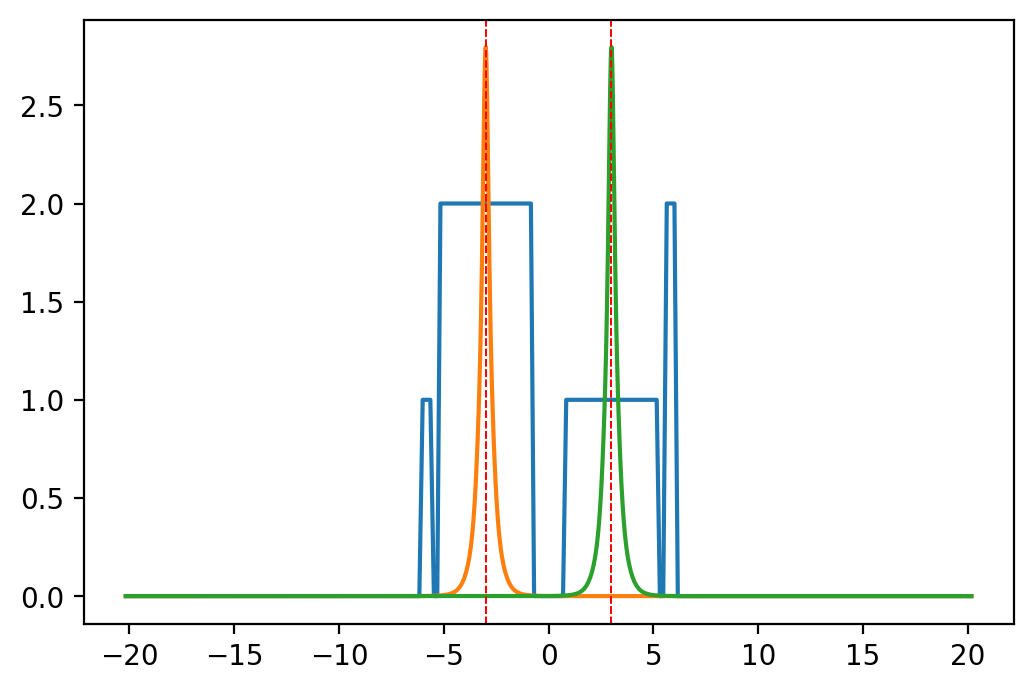

In [6]:
f,ax = plt.subplots(1,1, dpi=200)
n1 = mol.to_grid(2*f1.Da.np)
n2 = mol.to_grid(2*f2.Da.np)
n = mol.to_grid(2*mol.Da.np)
pdft.plot1d_x(w1, mol.Vpot, dimmer_length=bondlength, ax=ax)
pdft.plot1d_x(n1, mol.Vpot, dimmer_length=bondlength, ax=ax)
pdft.plot1d_x(n2, mol.Vpot, dimmer_length=bondlength, ax=ax)
# plot1d_x(n, mol.Vpot, dimmer_length=bondlength, ax=ax)

Text(0.5, 0, 'Z')

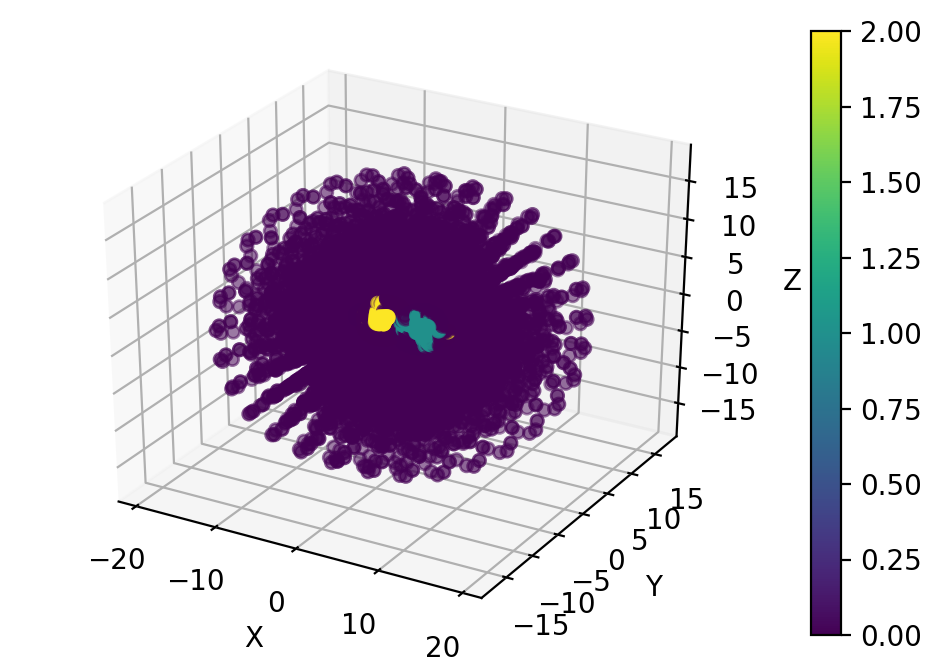

In [10]:
fig = plt.figure(dpi=200)
ax = fig.add_subplot(111, projection='3d')
p = ax.scatter(x, y, z, c=w1)
plt.colorbar(p)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

In [6]:
# Run with vp = vp_all96
energy, vp_all96, vp_fock_all96 = pdfter.find_vp_all96(100, 1000, rtol=1e-2, seperation_cutoff=bondlength/7.0)

Iteration  1, ALL96 E -0.04118598266743, ALL96 E difference 1.00000000000000
Iteration  2, ALL96 E -0.10182543780764, ALL96 E difference 0.59552363776488
Iteration  3, ALL96 E -0.23263890560292, ALL96 E difference 0.56230262713905
Iteration  4, ALL96 E -0.49167928718792, ALL96 E difference 0.52684826946146
Iteration  5, ALL96 E -0.76353471620828, ALL96 E difference 0.35604855057593
Iteration  6, ALL96 E -0.91153966558892, ALL96 E difference 0.16236808442671
Iteration  7, ALL96 E -1.02947401795550, ALL96 E difference 0.11455787160204
Iteration  8, ALL96 E -1.22721467120490, ALL96 E difference 0.16112963598720
Iteration  9, ALL96 E -1.67696810688481, ALL96 E difference 0.26819438833300
Iteration  10, ALL96 E -3.88115359714220, ALL96 E difference 0.56792019050222
Iteration  11, ALL96 E -9.92432487146729, ALL96 E difference 0.60892517653260
Iteration  12, ALL96 E -3.70152799917521, ALL96 E difference 1.68114272637642
Iteration  13, ALL96 E -5.87983300088161, ALL96 E difference 0.3704705561

In [11]:
def plot1d_x(data, Vpot, dimmer_length=None, title=None, ax= None):
    """
    Plot the given function (on the grid) on x axis.
    I found this really helpful for diatoms.

    :param data: Any f(r) on grid
    :param ax: Using ax created outside this function to have a better control.

    """
    x, y, z, w = Vpot.get_np_xyzw()
    # filter to get points on z axis
    mask = np.isclose(abs(y), 0, atol=1E-11)
    mask2 = np.isclose(abs(z), 0, atol=1E-11)
    order = np.argsort(x[mask & mask2])
    if ax is None:
        f1 = plt.figure(figsize=(16, 12), dpi=160)
        # f1 = plt.figure()
        plt.plot(x[mask & mask2][order], data[mask & mask2][order])
    else:
        ax.plot(x[mask & mask2][order], data[mask & mask2][order])
    if dimmer_length is not None:
        plt.axvline(x=dimmer_length/2.0)
        plt.axvline(x=-dimmer_length/2.0)
    if title is not None:
        if ax is None:
            plt.title(title)
        else:
            # f1 = plt.figure(num=fignum, figsize=(16, 12), dpi=160)
            ax.set_title(title)
    if ax is None:
        plt.show()

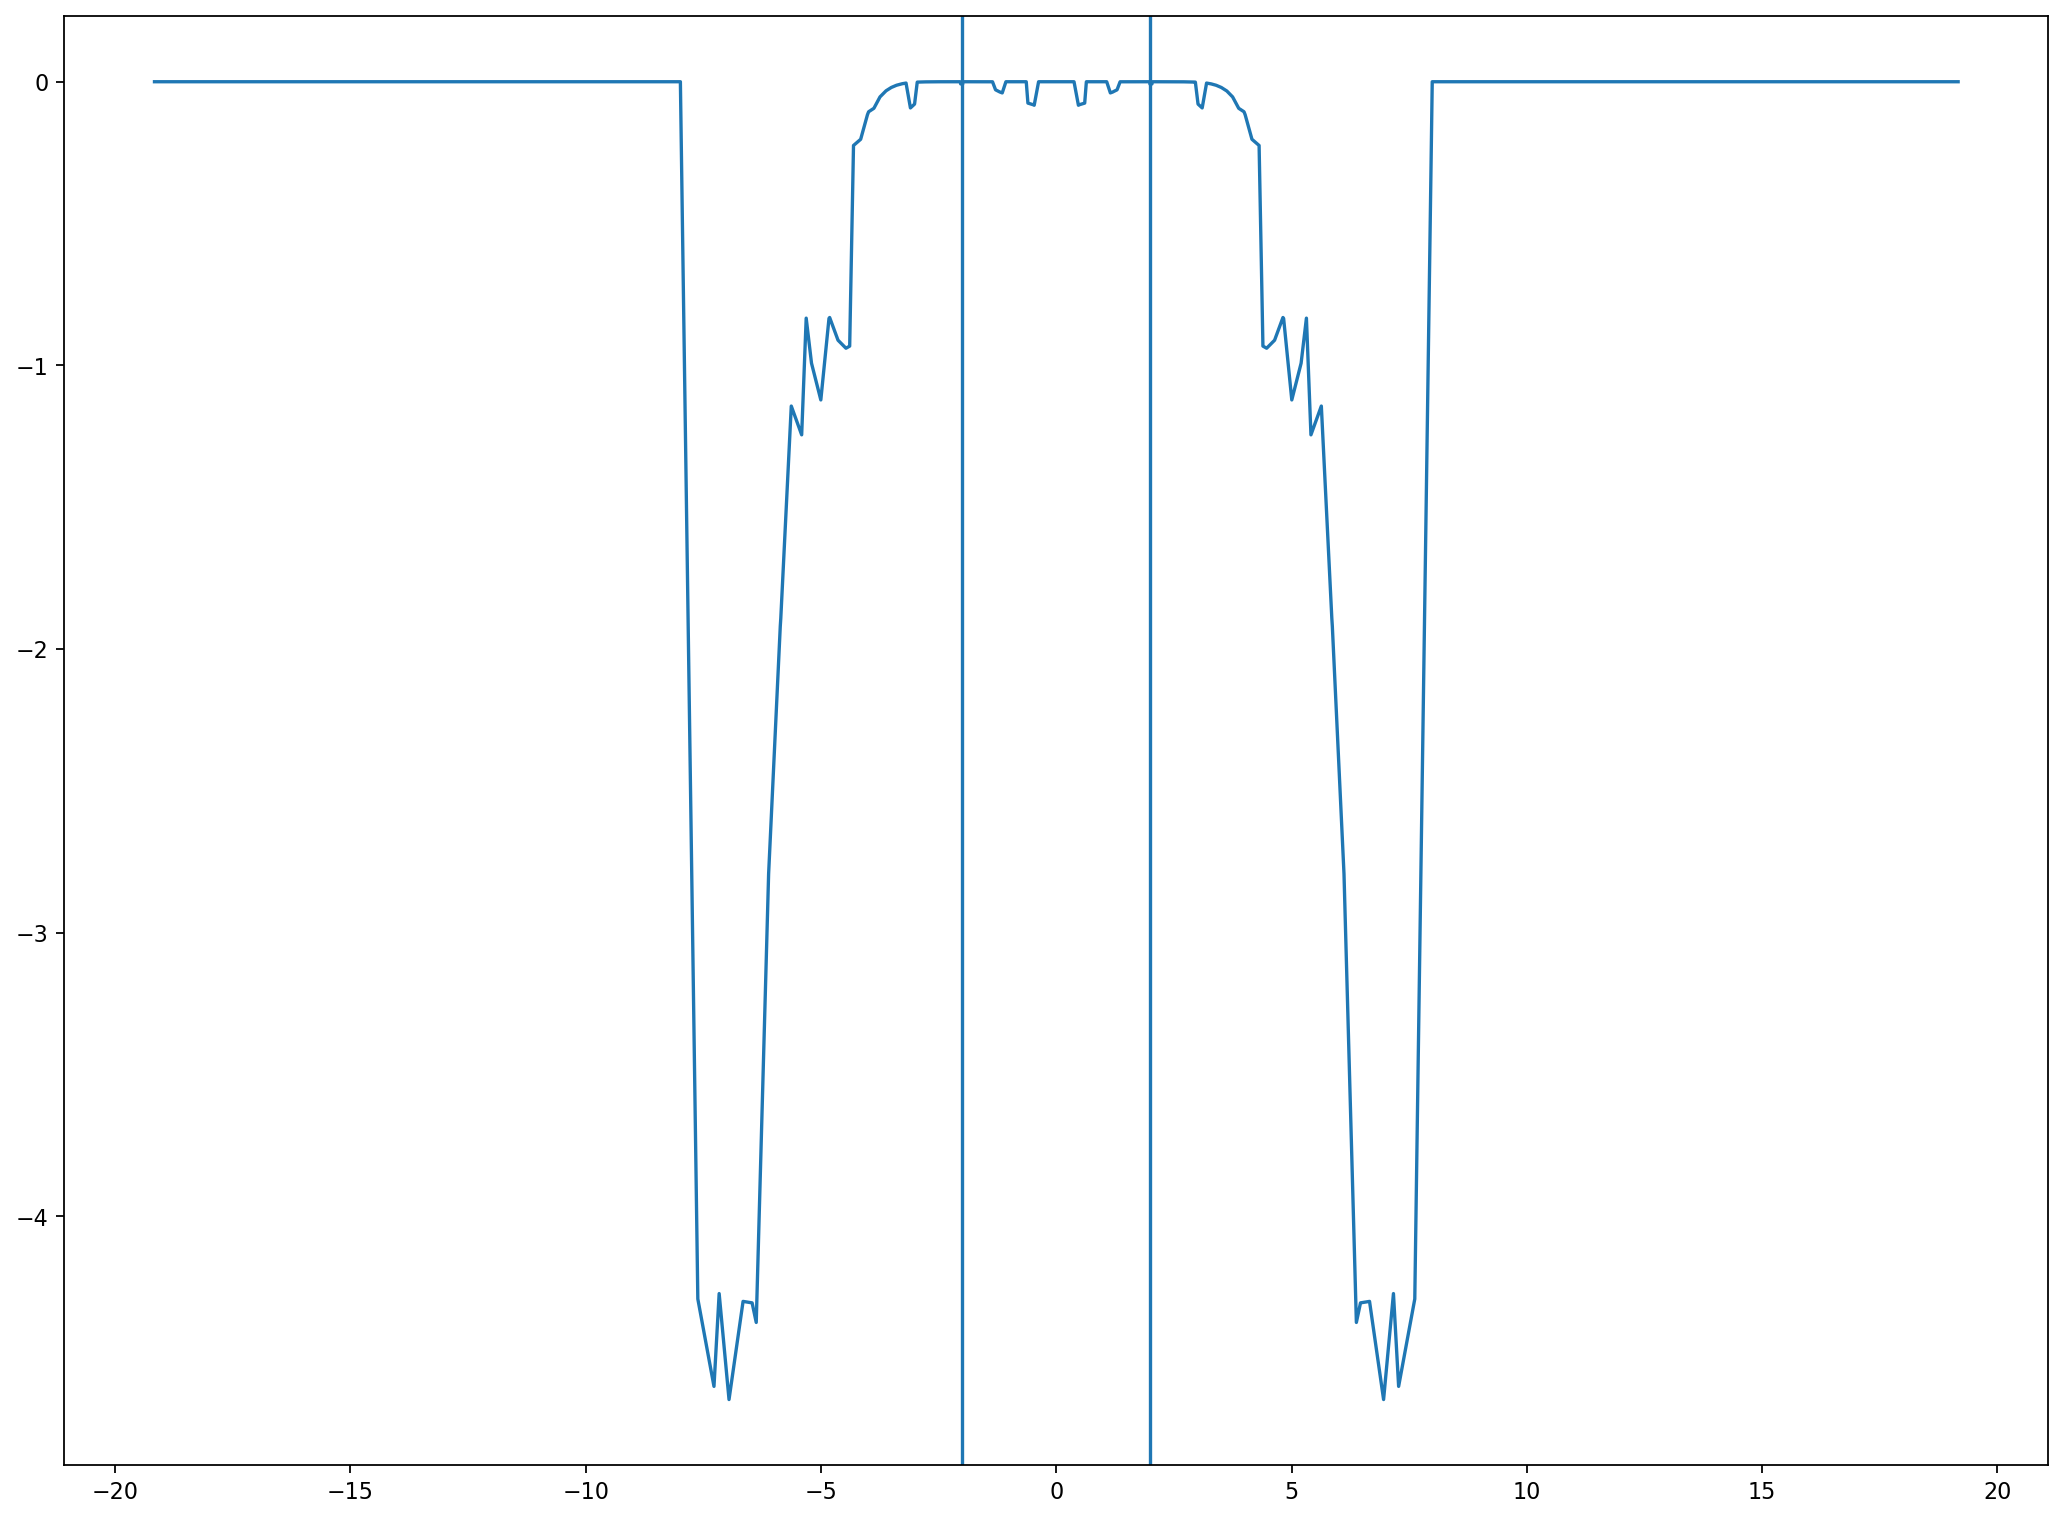

In [12]:
plot1d_x(vp_all96, mol.Vpot, dimmer_length=4)